# Collapsing traceroutes
this code
a) looks up all the unique traceroutes (according to hash).
b) prepends source site IP
c) checks all the paths to find ones having the same length and only one different device 
d) makes list of all the IPs, make a list of IP equivalences. 


In [1]:
%matplotlib inline
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from datetime import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
from datetime import datetime
import numpy as np
import pandas as pd

from perfsonar import path, link, mesh

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)
my_index = "network_weather_2-2016.9.*"

my_query = {}

##  Select your link

In [2]:
# srcSiteThroughputServer = "192.170.227.162"
srcSiteThroughputServer = "128.142.223.246"
# destSiteThroughputServer = "149.165.225.224"
# destSiteThroughputServer = "72.36.96.9"
# destSiteThroughputServer = "72.36.126.132"
destSiteThroughputServer = "193.109.172.187"

srcSiteThroughputServer='192.12.15.111'
destSiteThroughputServer = '192.170.227.162'

## Get the data from Elasticsearch, and store the record based on its type

In [3]:
my_query = {
    "size":1,
    "_source": {
        "include": [ 'src','dest','hops','hash' ]
    },
    'query':{
        'filtered':{
            'query': { "match_all": {} },
            'filter':{
                'bool':{
                    'must':[
                        {'range': {'timestamp': {'gte': '2016-09-15', 'lt': '2016-09-30'}}},
                        {'term': {'_type': 'traceroute'}},
                        {'bool':
                            {'should':[
                                {'term': {'src': srcSiteThroughputServer}},
                                {'term': {'src': destSiteThroughputServer}}
                            ]}
                        }
                        ,
                        {'bool':
                            {'should':[
                                {'term': {'dest': destSiteThroughputServer}},
                                {'term': {'dest': srcSiteThroughputServer}}
                            ]}
                        }
                    ]
                }
            }
        }
    },
    "aggs": {
        "grouped_by_hash": {
          "terms": { 
                "field": "hash",
                "size":0
            },
          "aggs": {
              "top_hash_hits": {
                  "top_hits": {
                      "sort": [ { "_score": { "order": "desc" } } ],
                      "size": 1
                  }
              }
          }
       }
    }
}

results = es.search(body=my_query, index=my_index, request_timeout=12000)

buckets=results['aggregations']['grouped_by_hash']['buckets']
print("all different hashes:", len(buckets))

results=[]
for b in buckets:
    res=b['top_hash_hits']['hits']['hits'][0]
    res['doc_count']=b['doc_count']
    results.append(res)

all different hashes: 29


In [4]:
AllLinks=mesh()
# count = 0
for res in results:
#     if count<1: print(res)
#     count += 1
    s = res['_source']['src']
    d = res['_source']['dest']
    L = AllLinks.addLink(s,d)
    L.addPath(path(res['_source']['hash'], res['_source']['hops'], res['doc_count']))

print('Total Links:', AllLinks.getNlinks())
print('AllIPs:', len(AllLinks.getIPs()))



Total Links: 2
AllIPs: 26


In [5]:
pathsPerLink=[]
c=0
for l in AllLinks.links:
    l.prnt()
    l.findEQs()
    l.equs.prnt()
    pathsPerLink.append(l.getNpaths())
    if c>200: break
    c+=1

src:  192.170.227.162 	dest: 192.12.15.111 	tests: 1815 	paths: 10 	randomNones: 5 	IPs: 14
seen: 1 	random None: True 	hops: ['192.170.227.162', '192.170.226.1', '192.170.224.77', '198.124.80.77', None, '198.124.80.50', '10.224.2.42', '192.12.15.111'] 	rtts: []
seen: 785 	random None: False 	hops: ['192.170.227.162', '192.170.226.1', '192.170.224.77', '198.124.80.77', '198.124.80.49', '198.124.80.50', '10.224.2.46', '192.12.15.111'] 	rtts: []
seen: 33 	random None: False 	hops: ['192.170.227.162', '192.170.226.1', '192.170.224.77', '198.124.80.77', '198.124.80.5', '198.124.80.6', '10.224.2.38', '192.12.15.111'] 	rtts: []
seen: 74 	random None: True 	hops: ['192.170.227.162', None, '192.170.224.77', '198.124.80.77', '198.124.80.49', '198.124.80.50', '10.224.2.46', '192.12.15.111'] 	rtts: []
seen: 780 	random None: False 	hops: ['192.170.227.162', '192.170.226.1', '192.170.224.77', '198.124.80.77', '198.124.80.49', '198.124.80.50', '10.224.2.42', '192.12.15.111'] 	rtts: []
seen: 1 	rand

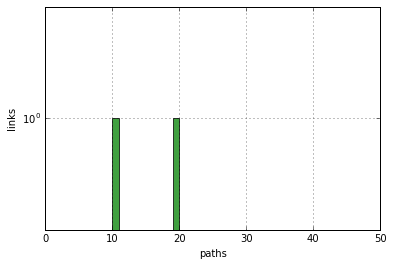

In [6]:
plt.hist(pathsPerLink, 49,range=[1, 50], facecolor='green', alpha=0.75)
plt.grid(True)
plt.xlabel('paths')
plt.ylabel('links')
plt.yscale('log', nonposy='clip')
plt.show()